In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def vector_product(x, y):
    return x[:, :, 0]*y[:, :, 1] - x[:, :, 1]*y[:, :, 0]

def intersect(x1, d1, x2, d2):
    """
    Arguments:
    x1, d1: (n, 2)
    x2, d2: (m, 2)
    return: tu: (n, m, 2)
        x1[k] + tu[k, l, 0] * d1[k] == x2[l] + tu[k, l, 1] * d2[l]
    """
    x1 = x1[:, None, :]
    x2 = x2[None, :, :]
    d1 = d1[:, None, :]
    d2 = d2[None, :, :]
    rs = vector_product(d1, d2)
    t = vector_product(x2 - x1, d2) / rs
    u = vector_product(x2 - x1, d1) / rs
    tu = np.stack([t, u], 2)
    m = np.any((tu < 0) | (tu > 1), axis=2)
    tu[m] = np.nan
    return tu

def make_rectangle(x1, x2):
    """
    Arguments:
    x1: lower left corner
    x2: upper right corner
    """
    dx = np.array([x2[0] - x1[0], 0])
    dy = np.array([0, x2[1] - x1[1]])
    
    return np.vstack([x1, x1, x2, x2]), np.vstack([dx, dy, -dx, -dy])

In [118]:
def alphas_to_coords(S, x0, y0, alphas):
    alphas = np.cumsum(alphas, 1)
    x = np.zeros((alphas.shape[0], alphas.shape[1]+1, 2))
    x[:, 0, :] = [x0, y0]
    d = np.stack([S * np.cos(alphas), S * np.sin(alphas)], 2)
    x[:, 1:, :] = d
    x = np.cumsum(x, 1)
    return x, d

# TODO: optimize if needed
def rectangle_penalty(s1, x1, s2, x2, rectangle_x, rectangle_d, max_h):
    if s1 == s2:
        return np.abs(np.sum(x2 - x1)) * max_h / 2
    elif s1 % 2 == s2 % 2:
        h = np.abs(rectangle_d[(s1+1) % 4, :].sum())
        s = min(s1, s2)
        a = np.abs(x1[s] - rectangle_x[0, s])
        b = np.abs(x2[s] - rectangle_x[0, s])
        S = (a + b) * h / 2
        S_total = rectangle_d[0, 0] * rectangle_d[1, 1]
        return min(S, S_total - S)
    else:
        x = np.abs(x2 - x1)
        return x[0] * x[1] / 2

def rectangle_total_penalty(specimen_x, specimen_d, rectangle_x, rectangle_d):
    n = specimen_d.shape[0]
    intersections = intersect(specimen_x[:-1, :], specimen_d, rectangle_x, rectangle_d)
    does_intersect = np.any(~np.isnan(intersections), 2)
    penalty = 0.
    intersection_side = None
    intersection_point = None
    max_h = 0.
    for i in range(n):
        if intersection_side is not None:
            s = (intersection_side+1) % 2
            max_h = max(max_h, np.abs(specimen_x[i, s] - intersection_point[s]))
        for j in range(4):
            if does_intersect[i, j]:
                j_point = specimen_x[i] + specimen_d[i] * intersections[i, j, 0]
                if intersection_side is not None:
                    penalty += rectangle_penalty(intersection_side, intersection_point, j, j_point, rectangle_x, rectangle_d, max_h)
                    intersection_side = None
                else:
                    intersection_side = j
                    intersection_point = j_point
                    max_h = 0.
    if intersection_side is not None:
        penalty += rectangle_d[0, 0] * rectangle_d[1, 1]
    return penalty

## Rectangle penalty tests

TODO: make into actual unit tests perhaps?

In [155]:
%%time
# x0 = 0.
# y0 = 1.5
# S = [0.9, 1., 0.9]
# alphas = -np.array([[np.pi / 2, -np.pi / 2, -np.pi / 2]])
x0 = 2.
y0 = 0.6
S = [1, 0.2, 3]
# alphas = np.array([[0, np.pi / 2, np.pi / 2]])
alphas = np.array([[np.pi, -np.pi / 2, np.pi / 2]])
x, d = alphas_to_coords(S, x0, y0, alphas)
rect_x, rect_d = make_rectangle([-0.5, 0.5], [1.5, 1.0])
x, d, rect_x, rect_d

CPU times: user 715 µs, sys: 59 µs, total: 774 µs
Wall time: 515 µs


(array([[[ 2. ,  0.6],
         [ 1. ,  0.6],
         [ 1. ,  0.8],
         [-2. ,  0.8]]]),
 array([[[-1.0000000e+00,  1.2246468e-16],
         [ 1.2246468e-17,  2.0000000e-01],
         [-3.0000000e+00,  3.6739404e-16]]]),
 array([[-0.5,  0.5],
        [-0.5,  0.5],
        [ 1.5,  1. ],
        [ 1.5,  1. ]]),
 array([[ 2. ,  0. ],
        [ 0. ,  0.5],
        [-2. , -0. ],
        [-0. , -0.5]]))

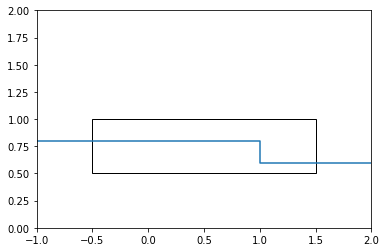

In [156]:
from matplotlib import patches

rect = patches.Rectangle(rect_x[0, :], rect_d[0, 0], rect_d[1, 1], edgecolor="k", facecolor=(0, 0, 0, 0))
fig, ax = plt.subplots()
ax.set_xlim(-1, 2.)
ax.set_ylim(0., 2.)
ax.add_patch(rect)
ax.plot(x[0, :, 0], x[0, :, 1])

In [157]:
%%time
intersects = intersect(x[0, :-1, :], d[0, :, :], rect_x, rect_d)

CPU times: user 282 µs, sys: 23 µs, total: 305 µs
Wall time: 192 µs


In [158]:
%%time
rectangle_total_penalty(x[0], d[0], rect_x, rect_d)

CPU times: user 1.28 ms, sys: 105 µs, total: 1.39 ms
Wall time: 1.21 ms


0.40000000000000036

## Misc

In [139]:
S = [1, 0.5, 0.5]
x0 = 1.
y0 = 2.
alphas = np.array([[np.pi / 4., -np.pi / 2., np.pi - np.pi / 6.]])

In [140]:
x, dx = alphas_to_coords(S, x0, y0, alphas)
x, dx

(array([[[1.        , 2.        ],
         [1.70710678, 2.70710678],
         [2.06066017, 2.35355339],
         [1.93125065, 2.8365163 ]]]),
 array([[[ 0.70710678,  0.70710678],
         [ 0.35355339, -0.35355339],
         [-0.12940952,  0.48296291]]]))

(0.9469669914110089,
 2.1136931803688124,
 1.9581741848131096,
 2.8783421189246985)

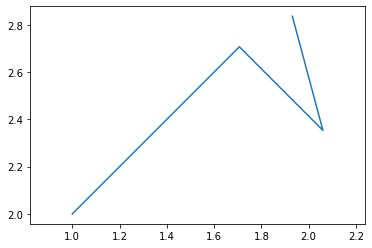

In [141]:
plt.plot(x[0, :, 0], x[0, :, 1])
plt.axis("equal")

In [142]:
make_rectangle(
    np.array([1., 1.]),
    np.array([2., 3.])
)

(array([[1., 1.],
        [1., 1.],
        [2., 3.],
        [2., 3.]]),
 array([[ 1.,  0.],
        [ 0.,  2.],
        [-1., -0.],
        [-0., -2.]]))

In [143]:
x1 = np.array([[0, 1],
               [0, 0.4]])
d1 = np.array([[0.66667, -0.66667],
               [0.2, -0.4]])
x2 = np.array([[0, 0],
               [0, 0.8]])
d2 = np.array([[1, 1],
               [0.2, 0.2]])

In [144]:
intersects = intersect(x1, d1, x2, d2)
intersects.shape

(2, 2, 2)

In [145]:
does_intersect = np.any(~np.isnan(intersects), (1, 2))
does_intersect

array([ True,  True])

In [146]:
intersects[0, 0]

array([0.74999625, 0.5       ])

In [147]:
intersects[0, 1]

array([0.14999925, 0.5       ])

In [148]:
intersects[1, 0]

array([0.66666667, 0.13333333])

In [149]:
intersects[1, 1]

array([nan, nan])

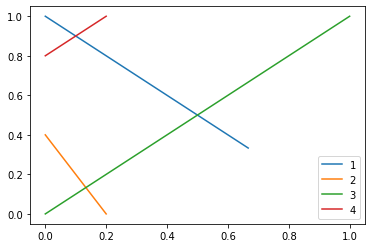

In [150]:
l1 = np.vstack([x1[0, :], x1[0, :]+d1[0, :]])
l2 = np.vstack([x1[1, :], x1[1, :]+d1[1, :]])
l3 = np.vstack([x2[0, :], x2[0, :]+d2[0, :]])
l4 = np.vstack([x2[1, :], x2[1, :]+d2[1, :]])

plt.plot(l1[:, 0], l1[:, 1], label="1")
plt.plot(l2[:, 0], l2[:, 1], label="2")
plt.plot(l3[:, 0], l3[:, 1], label="3")
plt.plot(l4[:, 0], l4[:, 1], label="4")
plt.legend()